---

title: **U-NET** Training Script (*v 1.0*)

author: Tiago Ribeiro

date: 15/03/2023

---

### 🏿 GPU and CUDA Configurations

In [2]:
from psutil import virtual_memory       
gpu = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
ram_gb = virtual_memory().total / 1e9
print(f'{gpu.s} with {round(ram_gb,1)} GB of available RAM.\n')
!nvcc --version

NVIDIA GeForce RTX 3090 with 34.2 GB of available RAM.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


### ⚙️ Model Configurations

In [125]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy  # binary cross-entropy          
from tensorflow.keras.metrics import Precision 
from tensorflow.keras.metrics import Recall
from segmentation_models.metrics import IOUScore        # Jaccard index

CONFIGS = dict(
    BATCH_SZ = 4,
    IMG_SIZE = (256, 256),   
    SEED = 42,               
    CLASS_NUM = 1,        
    EPOCHS = 25,             
    OPTIMIZER = Adam(learning_rate=0.001), 
    LOSS = BinaryCrossentropy(label_smoothing=0.1),              
    CONV_ACTIV = Activation(tf.nn.relu),    
    DTYPE = np.float32,                      
    METRICS = [IOUScore(threshold = 0.5),
               Precision(thresholds=0.5), 
               Recall(thresholds=0.5)],
)

### 📁 Data source paths and directory creation

In [80]:
import os
from glob import glob
DIR = os.getcwd()
ANN_FILE = os.path.join(DIR, 'data_800_600\\result.json')
IMGS_DIR = os.path.join(DIR, 'data_800_600\\images')
MSKS_DIR = os.path.join(DIR, 'data_800_600\\masks')
NO_LABEL_DIR = os.path.join(DIR, 'output_Waternet')
imgs_no_lbl_paths = sorted(glob(NO_LABEL_DIR + '\\C5\\**\\*.png', recursive=True) +
                           glob(NO_LABEL_DIR + '\\C6\\**\\*.png', recursive=True)) 
CHCKPNT_MODELS = os.path.join(DIR, 'checkpoints\\unet_v1')
LOGS = os.path.join(DIR, 'logs\\unet_v1')
os.makedirs(LOGS, exist_ok=True)

### 🔩 Model Definition

In [10]:
import tensorflow as tf
from keras_unet_collection import models
from keras import backend

# forces channel-last order (N,H,W,C)
backend.set_image_data_format('channels_last')
tf.keras.backend.clear_session()
model = models.unet_2d(input_size = (CONFIGS['IMG_SIZE'] + (3,)), 
                       filter_num = [128, 256, 512, 1024, 2048],  
                       n_labels = 1, 
                       stack_num_down=2, 
                       stack_num_up=2,
                       activation='ReLU', 
                       output_activation='Sigmoid', 
                       batch_norm=False, 
                       pool=True, 
                       unpool=False, # Conv2DTranspose 
                       # backbone = 'VGG19',
                       # weights='imagenet', 
                       # freeze_backbone=False,  
                       freeze_batch_norm=True, 
                       name='unet')

#### Model Compilation

In [100]:
model.compile(optimizer = CONFIGS['OPTIMIZER'], 
              loss =  CONFIGS['LOSS'],
              metrics= [CONFIGS['METRICS']]
             )

### 🖼️ Data Augmentation

#### Data Augmentation Configurations

In [118]:
ROT_RANGE = 30
SHEAR_RANGE = 0.2
FILL_MODE = 'nearest'
HORIZ_FLIP = True
ZOOM_RANGE = [0.7, 1]
BRIGHT_RANGE = [0.8, 1.2]

#### Images generator

In [119]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(rotation_range = ROT_RANGE,
                             shear_range = SHEAR_RANGE,
                             fill_mode=FILL_MODE,        # "constant", "nearest", "reflect" or "wrap"
                             horizontal_flip = HORIZ_FLIP, 
                             zoom_range = ZOOM_RANGE,
                             brightness_range = BRIGHT_RANGE,
                             validation_split = 0.15,
                             rescale=1./255)
img_gen_valid = ImageDataGenerator(validation_split = 0.15,
                                   rescale=1./255)

img_trn_dset = img_gen.flow_from_directory(directory = IMGS_DIR,
                                           batch_size = CONFIGS['BATCH_SZ'],
                                           target_size = CONFIGS['IMG_SIZE'],
                                           color_mode="rgb",
                                           class_mode=None,
                                           subset="training",
                                           seed = CONFIGS['SEED'])

img_vld_dset = img_gen_valid.flow_from_directory(directory = IMGS_DIR,
                                                 batch_size = CONFIGS['BATCH_SZ'],
                                                 target_size = CONFIGS['IMG_SIZE'],
                                                 color_mode="rgb",
                                                 class_mode=None,
                                                 subset="validation",
                                                 seed = CONFIGS['SEED'])

Found 68 images belonging to 1 classes.
Found 11 images belonging to 1 classes.


#### Masks generator

In [39]:
msk_gen = ImageDataGenerator(rotation_range = ROT_RANGE,
                             shear_range = SHEAR_RANGE,
                             fill_mode=FILL_MODE,        
                             horizontal_flip = HORIZ_FLIP, 
                             zoom_range = ZOOM_RANGE,
                             validation_split = 0.15,
                             rescale=1./255)

msk_gen_valid = ImageDataGenerator(validation_split = 0.15,
                                   rescale=1./255)

msk_trn_dset = msk_gen.flow_from_directory(directory = MSKS_DIR,
                                           batch_size = CONFIGS['BATCH_SZ'],
                                           target_size = CONFIGS['IMG_SIZE'],
                                           color_mode="grayscale",
                                           class_mode=None,
                                           subset="training",
                                           seed = CONFIGS['SEED'])

msk_vld_dset = msk_gen_valid.flow_from_directory(directory = MSKS_DIR,
                                                 batch_size = CONFIGS['BATCH_SZ'],
                                                 target_size = CONFIGS['IMG_SIZE'],
                                                 color_mode="grayscale",
                                                 class_mode=None,
                                                 subset="validation",
                                                 seed = CONFIGS['SEED'])

Found 68 images belonging to 1 classes.
Found 11 images belonging to 1 classes.


#### Data Augmentation Visualization (*Sanity Check*)

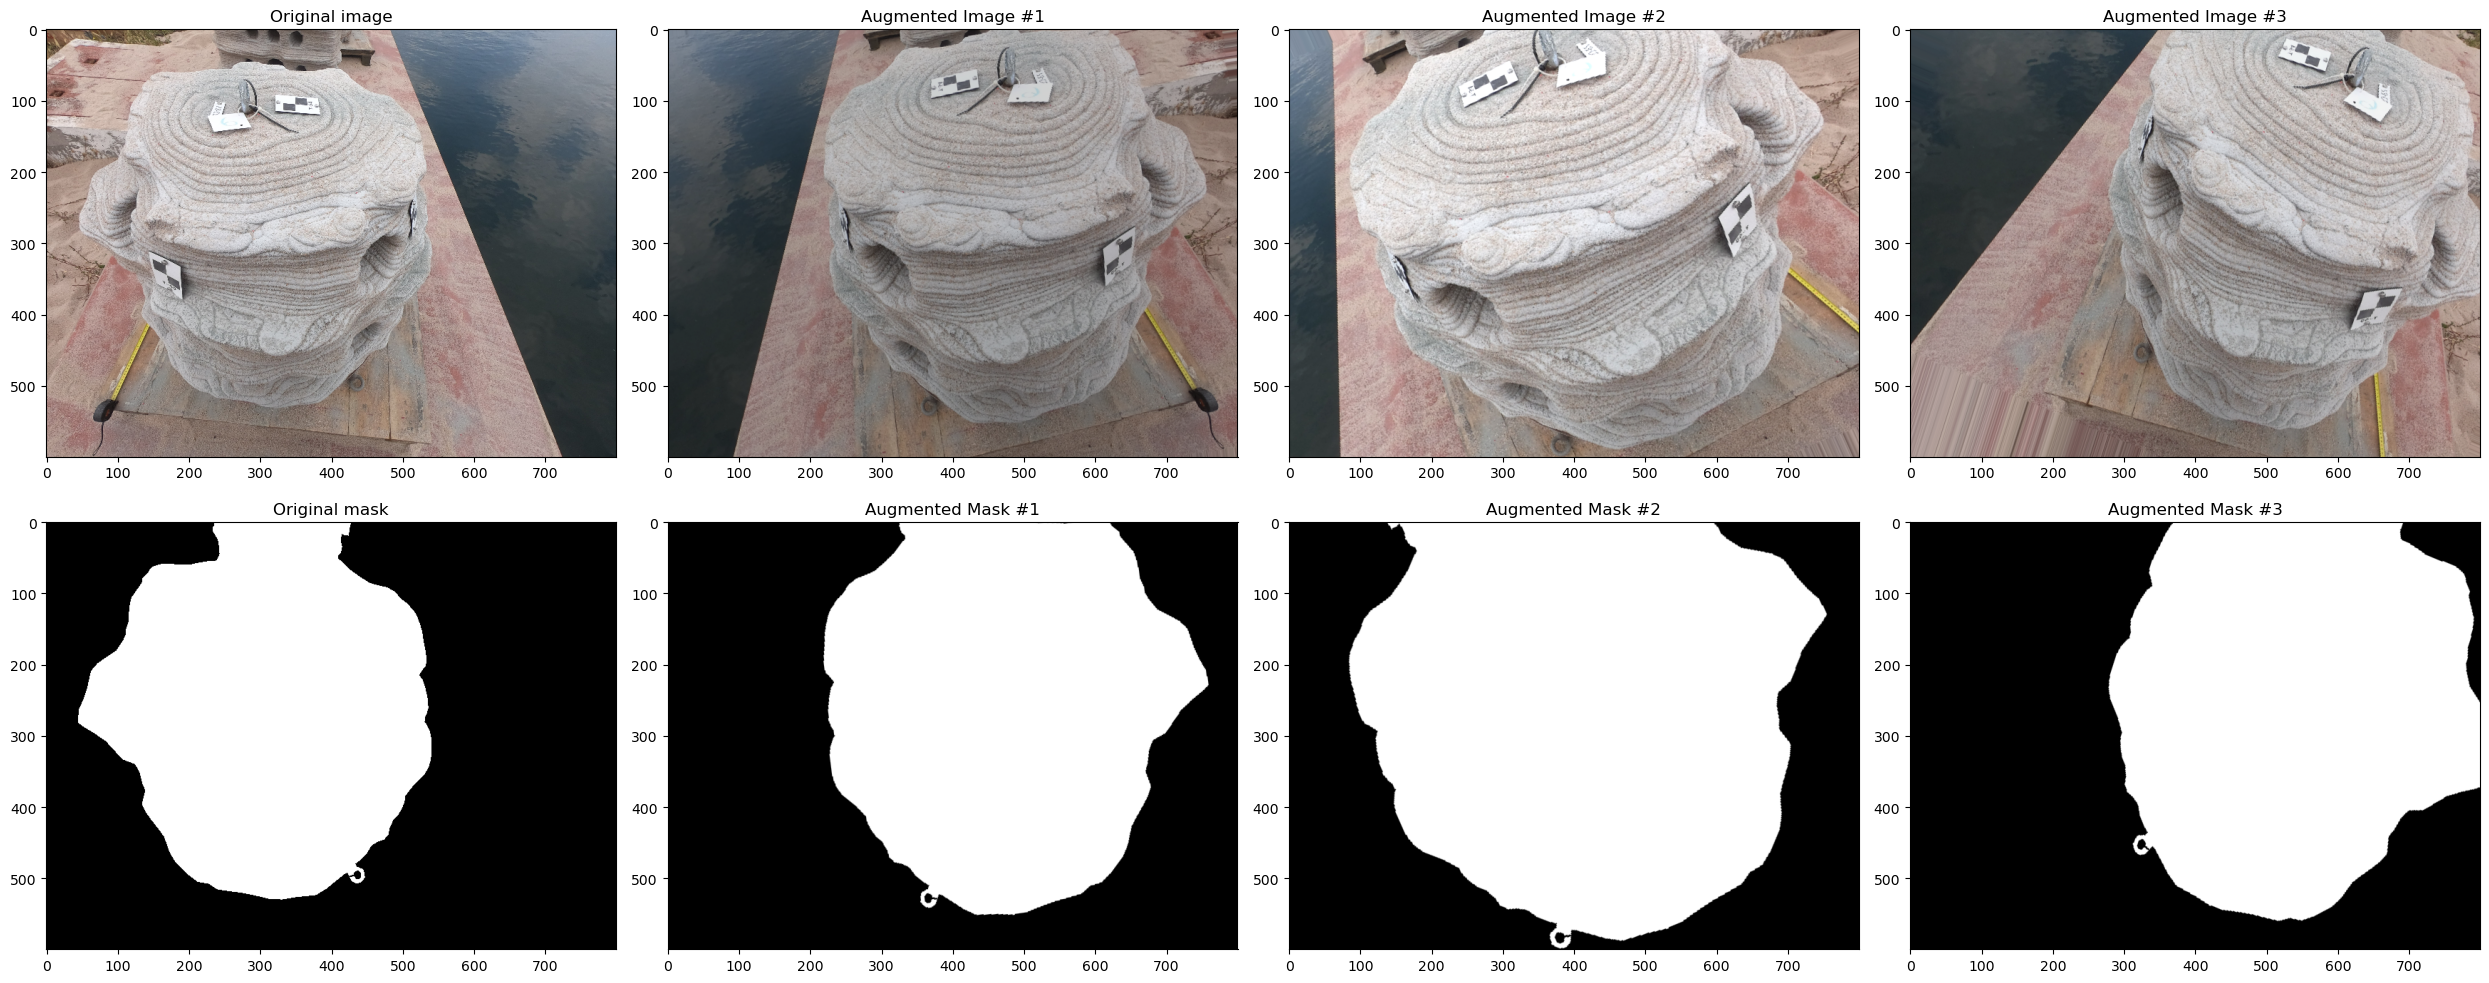

In [120]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
from glob import glob
import random

img_paths = sorted(glob(IMGS_DIR + '\\0\\*.PNG')) 
idx = random.choice(range(0, len(img_paths)-1))

img = load_img(img_paths[idx])
img_exp = np.expand_dims(img, axis=0)
img_iter = img_gen.flow(img_exp, batch_size=1, seed = CONFIGS['SEED'])

msks_paths = sorted(glob(MSKS_DIR + '\\0\\*.PNG')) 
msk = load_img(msks_paths[idx])
msk_exp = np.expand_dims(msk, axis=0)
msk_iter = msk_gen.flow(msk_exp, batch_size=1, seed = CONFIGS['SEED'])

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,10))

ax[0,0].imshow(img)
ax[0,0].set_title("Original image")

ax[1,0].imshow(msk)
ax[1,0].set_title("Original mask")

for i in range(3):
    image = next(img_iter)[0]
    ax[0, i+1].set_title(f"Augmented Image #{i+1}")
    ax[0, i+1].imshow(image)

    mask = next(msk_iter)[0]
    ax[1, i+1].set_title(f"Augmented Mask #{i+1}")
    ax[1, i+1].imshow(mask)

plt.tight_layout();

##### create_run_string

In [54]:
from datetime import datetime
def create_run_string(img_size, model_name = "NN",fold=None, use_cross_val=False):
    """Create a string for each training run.

    Args:
        img_size (tuple): The size (height, width) of the images.
        model_name: (str,optional): the designation of the model. Defaults to "NN".
        fold (int, optional): The fold number for cross-validation. Defaults to None.
        use_cross_val (bool, optional): Whether or not to use cross-validation. Defaults to False.

    Returns:
        str: The string for the training run.
    """
    now = datetime.now()
    dt_string = now.strftime("%d_%b_%Hh%Mmin")
    str_run = f"{model_name}_{img_size[0]}x{img_size[1]}_DT_{dt_string}"
    if use_cross_val:
        str_run += f"_fold_{fold}"
    return str_run

##### metrics_graphs

In [68]:
def metrics_graphs(history, model, model_conf="not provided!", metrics=['loss'], y_log=False):
    """
    Plots training and validation metrics of a Keras model during training.
    Parameters:
    -----------
    history: tf.keras.callbacks.History
        Object returned by model.fit() containing training history.
    model: tf.keras.Model
        The trained machine learning model.
    conf_modelo: str, optional (default="")
        The configuration of the model (optional)
    metrics: list of str, optional (default=['loss'])
        The metrics to plot. Must be keys in the history object.
    y_log: bool, optional(default=False) 
        Whether to use logarithmic scale for the y-axis on the loss plot. Defaults to False.
    """

    if not isinstance(history, tf.keras.callbacks.History):
        raise TypeError("The 'history' argument must be a tf.keras.callbacks.History object.")
    if not isinstance(model, tf.keras.Model):
        raise TypeError("The 'model' argument must be a tf.keras.Model object.")
    if not isinstance(model_conf, str):
        raise TypeError("The 'model_conf' argument must be a string.")
        
    plt.style.use('fast') 

    n_metrics = len(metrics)
    fig, axs = plt.subplots(1, n_metrics, figsize=(25, 8))

    if n_metrics == 1:
        axs = [axs]

    for i, metric in enumerate(metrics):
        if metric not in history.history or f"val_{metric}" not in history.history:
            raise ValueError(f"{metric} not found in the history object.")

        axs[i].plot(history.history[metric], "limegreen", marker=".", alpha=0.7)
        axs[i].plot(history.history[f"val_{metric}"], "orangered", marker=".", alpha=0.7)
        axs[i].set_title(f"{metric.title()} of {model.name}\nConfiguration: {model_conf}")
        axs[i].set_ylabel(metric.title())
        axs[i].set_xlabel('Epoch')
        axs[i].legend(['train', 'validation'], loc='best')
        axs[i].grid(linestyle='--', linewidth=0.4)

        # Creates box indicating maximum validation metric
        xmax = np.argmax(history.history[f"val_{metric}"])
        ymax = max(history.history[f"val_{metric}"])
        text = f"{metric.title()} Val.: {ymax:.3f}"
        bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.5)
        arrowprops1 = dict(arrowstyle="->", connectionstyle="arc3,rad=0.3")
        kw = dict(xycoords='data', textcoords="offset points",
                  arrowprops=arrowprops1, bbox=bbox_props, ha="right", va="center")
        axs[i].annotate(text, xy=(xmax, ymax), xytext=(-15, -30), **kw)

        if metric == 'loss' and y_log:
            axs[i].set_yscale('log')

    plt.tight_layout()

##### callback_funcs

In [91]:
def callback_funcs(str_run, monitor_metric='val_loss', mode='min', reduce_factor=0.5,
                   reduce_patience=10, fold_n=0, additional_callbacks=[], callback_list=[]):
    """
    Creates a list of Keras callbacks to be used during model training.

    Parameters
    ----------
    str_run : str
        Prefix for the filenames of the CSVLogger and ModelCheckpoint callbacks.
    monitor_metric : str, optional
        Name of the metric to monitor for the ReduceLROnPlateau and ModelCheckpoint callbacks. 
        Default is 'loss'.
    mode : str, optional
        One of {'min', 'max', 'auto'}. 
        Specifies whether the monitored metric should be minimized, maximized, or inferred automatically for the ModelCheckpoint callback. 
        Default is 'min'.
    reduce_factor : float, optional
        Factor by which to reduce the learning rate when there is no improvement in monitored metric after reduce_patience epochs.
        Default is 0.5.
    reduce_patience : int, optional
        Number of epochs with no improvement after which to reduce the learning rate for the ReduceLROnPlateau callback.
        Default is 10.
    additional_callbacks : list, optional
        List of additional Keras callbacks to be added to the output list.
        Default is [].
    callback_list : list, optional
        List of callback names to activate. 
        Available options are 'csv_logger', 'reduce_lr', and 'checkpoint'.
        Default is [] which activates all callbacks.

    Returns
    -------
    list
        A list of Keras callbacks to be used during model training.

    """   

    # Learning Schedule
    # Reduce learning rate when there is no improvement in monitored metric after a certain number of epochs
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=reduce_factor,
        mode=mode,
        patience=reduce_patience,
        verbose=1,
        min_lr=1e-6)
    
    # Training Logs
    # Log training metrics to a CSV file
    csv_logger = tf.keras.callbacks.CSVLogger(
        os.path.join(LOGS, str_run + '.csv'),
        separator=",",
        append=True)
    
    # Model Checkpoint
    # Save the best model based on monitored metric on validation data
    checkpoint_filepath = os.path.join(CHCKPNT_MODELS, str_run +'.h5')
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        mode=mode,
        verbose=1,
        monitor=monitor_metric)
    
    callbacks = []
    
    if not callback_list:
        callbacks = [csv_logger, reduce_lr, checkpoint] + additional_callbacks
    else:
        if 'csv_logger' in callback_list:
            callbacks.append(csv_logger)
        if 'reduce_lr' in callback_list:
            callbacks.append(reduce_lr)
        if 'checkpoint' in callback_list:
            callbacks.append(checkpoint)
        callbacks += additional_callbacks
    
    return callbacks


In [44]:
train_generator = zip(img_trn_dset, msk_trn_dset)
valid_generator = zip(img_vld_dset, msk_vld_dset)

#### Learning Rate Finder 

In [126]:
%%time
from lr_find import LrFinder
from one_cycle import OneCycleLr
# Instantiate LrFinder
lr_find = LrFinder(model, CONFIGS['OPTIMIZER'], CONFIGS['LOSS'])
# Start range_test
lr_find.range_test(train_generator, num_iter=1000)

Finding best initial lr over 1000 steps


  0%|          | 0/1000 [00:00<?, ?it/s]

LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.
CPU times: total: 6min 17s
Wall time: 6min 20s


Min numerical gradient: 1.29E-07
Min loss divided by 10: 1.64E-05


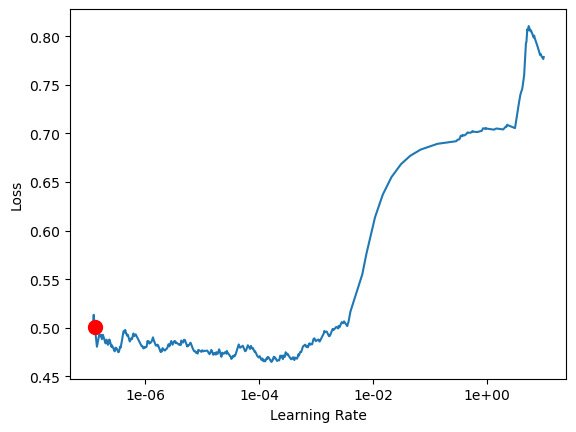

In [127]:
lr_find.plot_lrs(skip_end=0, suggestion=True)

In [131]:
# Define max learning rate for OneCycleLr
max_lr = 1E-06
# Instantiate OneCycleLr
one_c = OneCycleLr(max_lr=max_lr, steps_per_epoch=(img_trn_dset.n // CONFIGS['BATCH_SZ'])*5, epochs=1000)

### 🏋🏽 Training the model

In [132]:
%%time
str_run = create_run_string(img_size = CONFIGS['IMG_SIZE'] , model_name = "unet_v1") 
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = 1000,
                    batch_size = CONFIGS['BATCH_SZ'],
                    verbose = 1,
                    steps_per_epoch = (img_trn_dset.n // CONFIGS['BATCH_SZ'])*5,
                    validation_steps = img_vld_dset.n // CONFIGS['BATCH_SZ'],
                    validation_batch_size = CONFIGS['BATCH_SZ'],
                    callbacks = callback_funcs(str_run = str_run, 
                                               callback_list = ['checkpoint'], 
                                               additional_callbacks=[one_c])
                    )        

Epoch 1/1000
85/85 [==============================] - ETA: 0s - loss: 0.4796 - iou_score: 0.6854 - precision_4: 0.8175 - recall_4: 0.8133
Epoch 1: val_loss improved from inf to 0.35404, saving model to c:\Users\tiago\miniconda3\envs\tf2_10\reefs\checkpoints\unet_v1\unet_v1_256x256_DT_16_Mar_09h48min.h5
85/85 [==============================] - 27s 308ms/step - loss: 0.4796 - iou_score: 0.6854 - precision_4: 0.8175 - recall_4: 0.8133 - val_loss: 0.3540 - val_iou_score: 0.8593 - val_precision_4: 0.9002 - val_recall_4: 0.9498
Epoch 2/1000
85/85 [==============================] - ETA: 0s - loss: 0.4764 - iou_score: 0.6865 - precision_4: 0.8137 - recall_4: 0.8153
Epoch 2: val_loss did not improve from 0.35404
85/85 [==============================] - 24s 283ms/step - loss: 0.4764 - iou_score: 0.6865 - precision_4: 0.8137 - recall_4: 0.8153 - val_loss: 0.3678 - val_iou_score: 0.8314 - val_precision_4: 0.8590 - val_recall_4: 0.9655
Epoch 3/1000
85/85 [==============================] - ETA: 0s -

### End Training

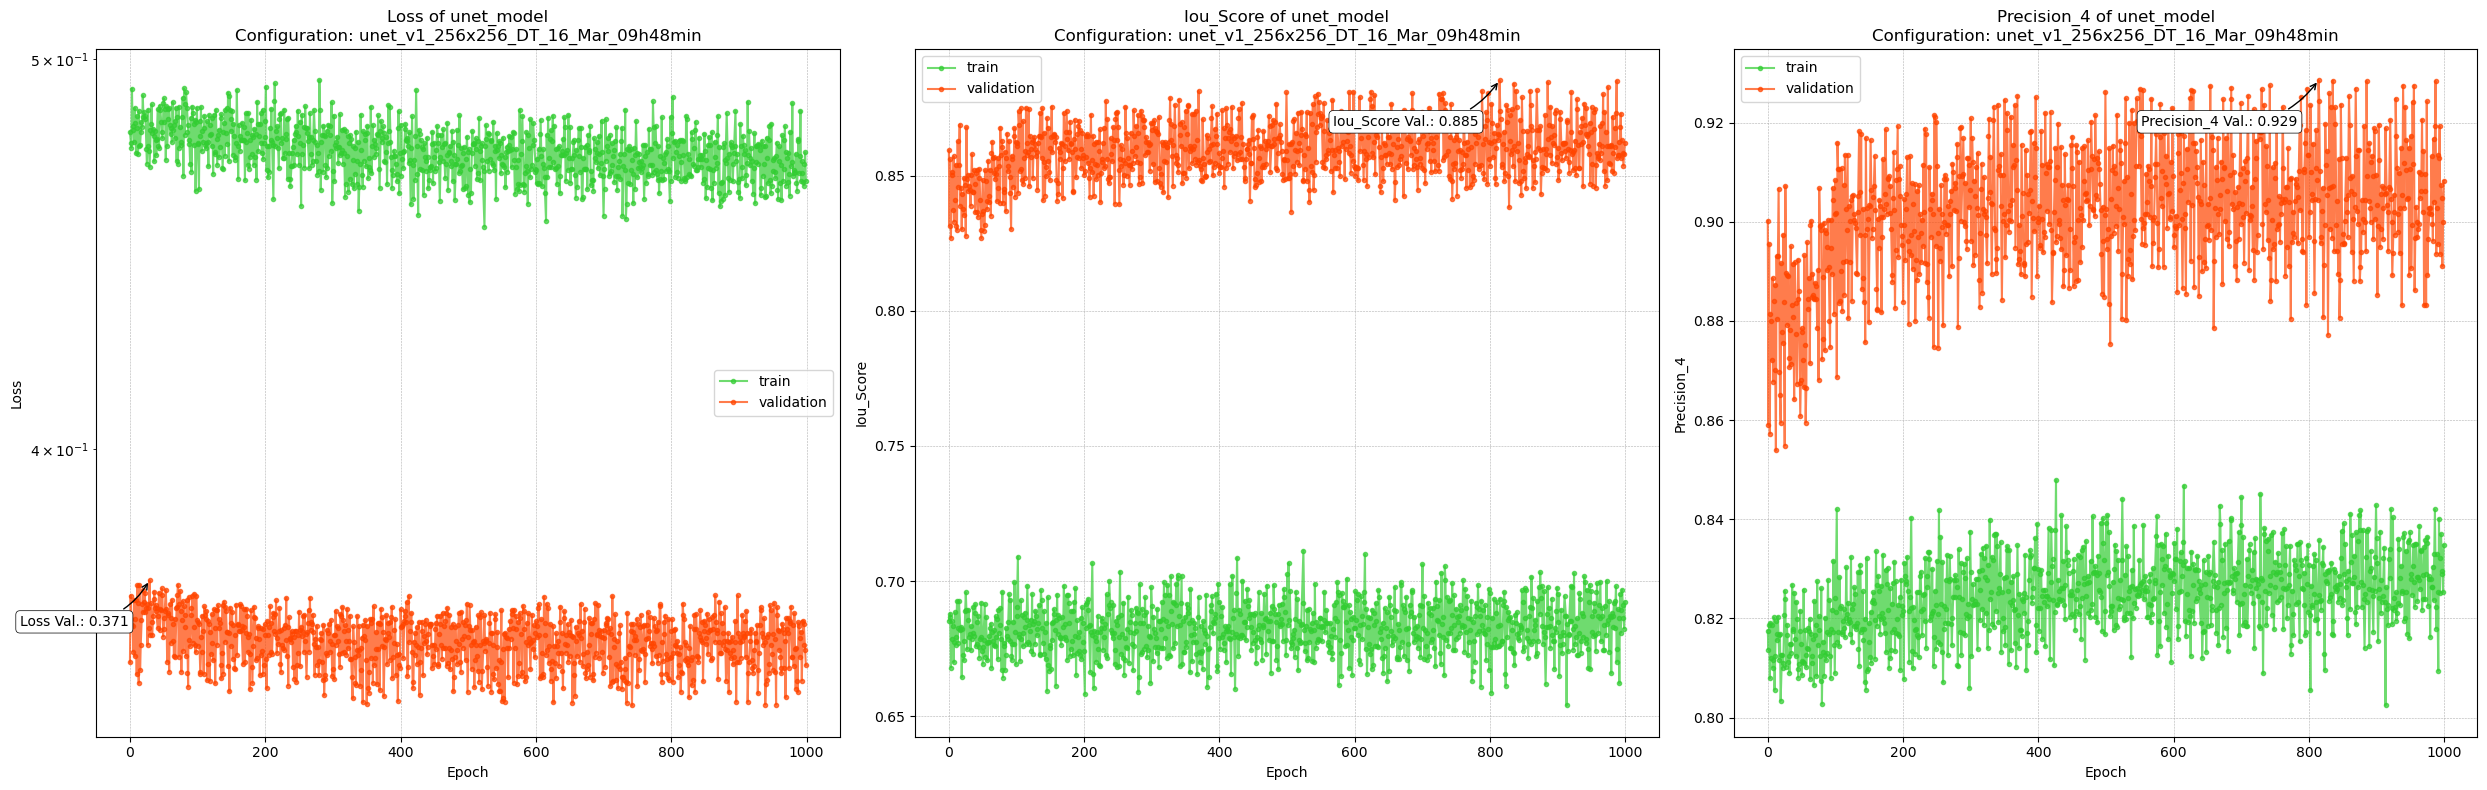

In [148]:
# Plots training metrics
metrics_graphs(history, model=model, model_conf = str_run, y_log=True, metrics=['loss', 'iou_score', 'precision_4'])

### 🔮 Inference 

1/1 [==============================] - 0s 19ms/step


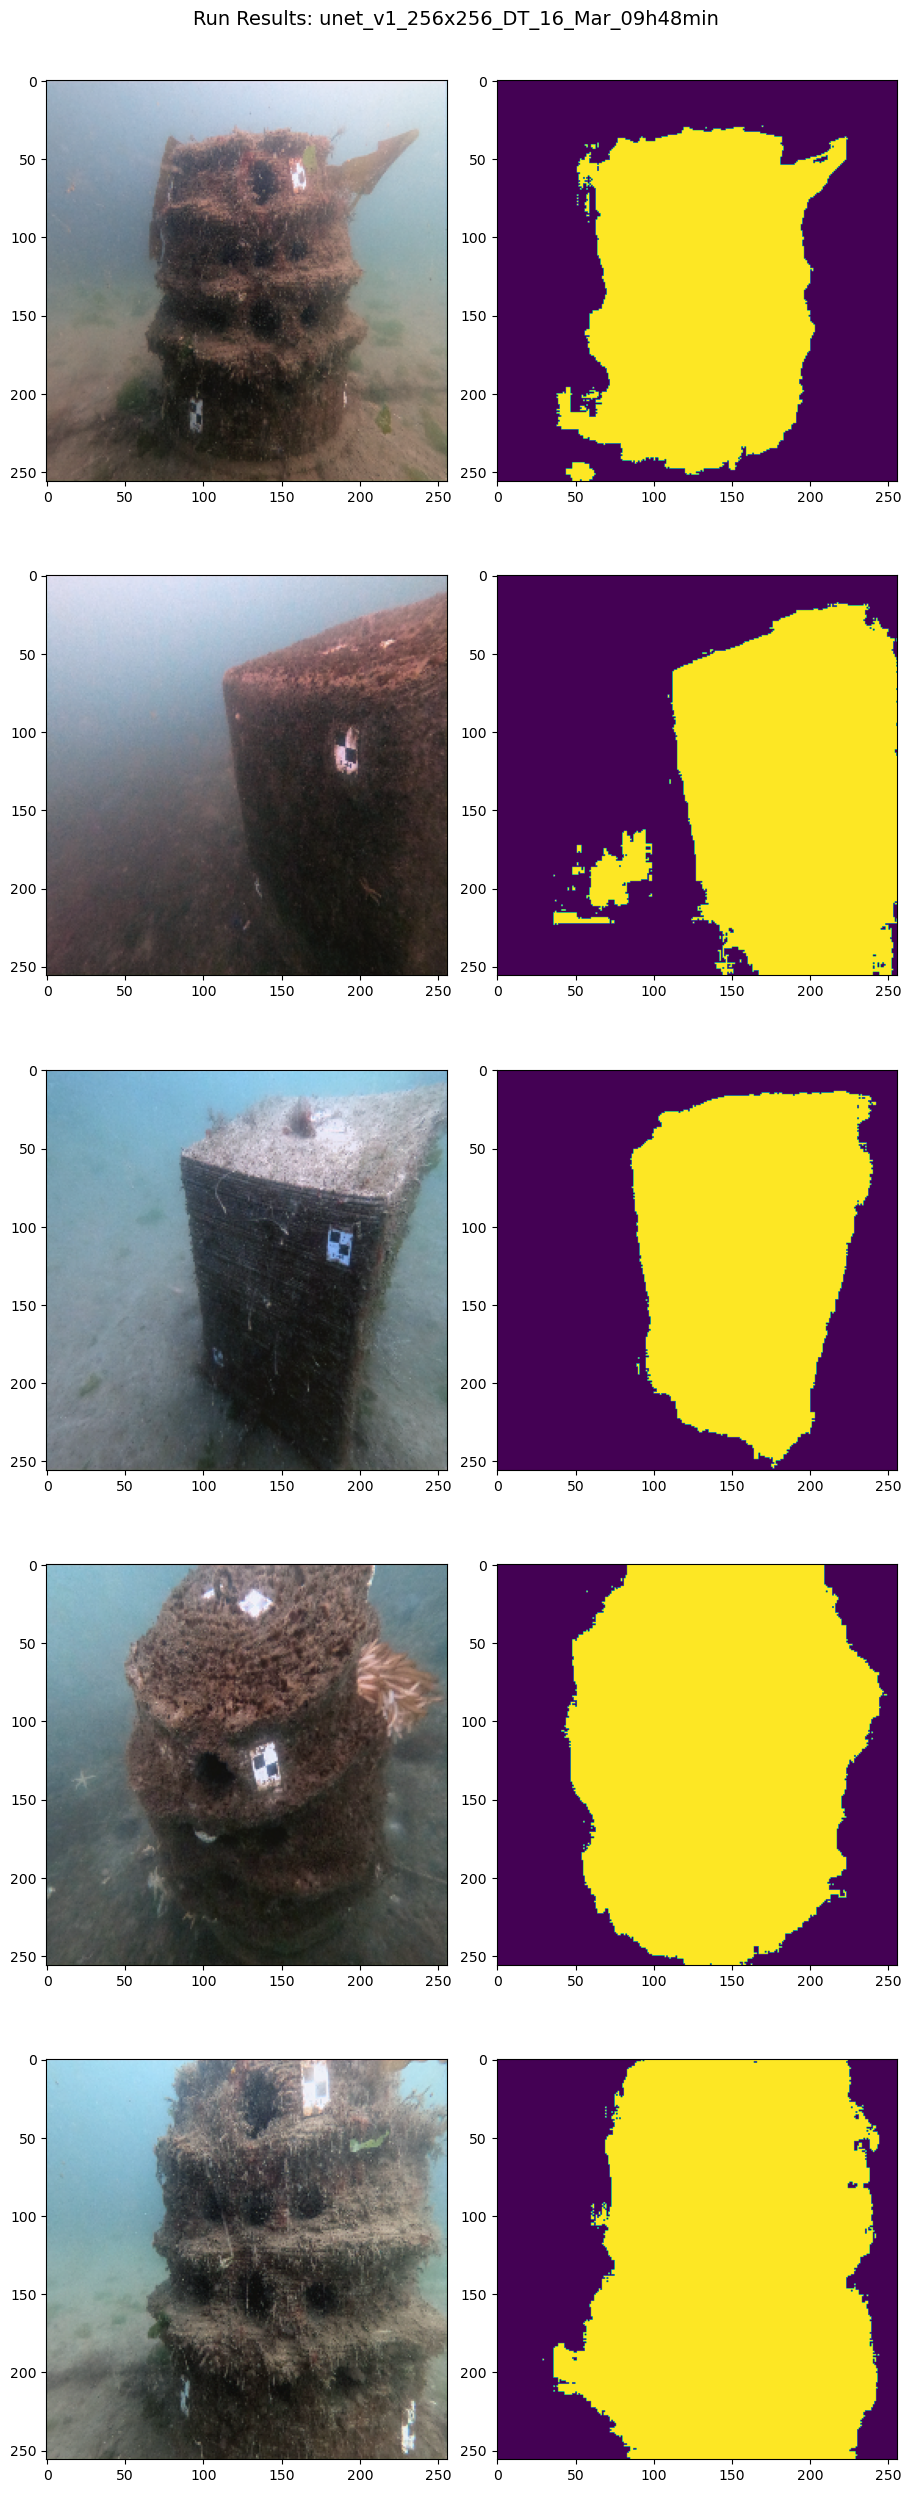

In [135]:
model = tf.keras.models.load_model(CHCKPNT_MODELS + '\\'+str_run+'.h5',
                                   custom_objects={'iou_score': IOUScore(threshold = 0.5)})

pred_list = list()
img_list = list()
img_idx = random.sample(range(len(imgs_no_lbl_paths)), 5)
for i in range(5):
    img = tf.io.decode_jpeg(tf.io.read_file(imgs_no_lbl_paths[img_idx[i]]), channels=3)
    img = tf.image.resize(img, CONFIGS['IMG_SIZE'])
    img_list.append(img)
    img_exp = tf.expand_dims(img, axis=0)
    img_exp = tf.cast(img_exp, dtype=tf.float32) / tf.constant(256, dtype=tf.float32)
    pred = model.predict(img_exp)
    pred_list.append(pred[0] > 0.5)
    
fig, axs = plt.subplots(5, 2, figsize=(9,25), constrained_layout=True)
j = 0
for img, pred in zip(img_list, pred_list):
    axs[j, 0].imshow(np.asarray(img).astype("int"))
    axs[j, 1].imshow(np.asarray(pred).astype("int"))
    j += 1
plt.suptitle('Run Results: '+ str_run, fontsize=14);
plt.tight_layout;